In [39]:
# tensorboard --logdir=logs

In [40]:
from __future__ import print_function

import argparse
import os
import random
import sys

import numpy as np

In [41]:
import shutil

# make or reset directory
def mk_reset_dir(directory):
    if os.path.exists(directory):
        try:
            shutil.rmtree(directory)
            os.mkdir(directory)
        except:
            print("error:", directory)
    else:
        try:
            os.mkdir(directory)
        except:
            print("error create:", directory)

In [42]:
# getting parent directory
# project_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))

In [43]:
# setting data path data seperated by class name
training_dir = r"data/input/train"
testing_dir = r"data/input/test"
validation_dir = r"data/input/val"

# setting output directory
model_dir =  r"data/output/models/"
log_dir = r"data/output/logs"

In [44]:
# # setting data path data seperated by class name
# training_dir = "data\\input\\train"
# testing_dir = "data\\input\\test"
# validation_dir = "data\\input\\val"

# # joining path with parent path 
# training_dir = os.path.join(project_dir, training_dir)
# testing_dir = os.path.join(project_dir, testing_dir)
# validation_dir = os.path.join(project_dir, validation_dir)


# # setting output directory
# model_dir = "data\\outputs\\models"
# log_dir = "data\\outputs\\logs"

# # joining path with parent path 
# model_dir = os.path.join(project_dir, model_dir)
# log_dir = os.path.join(project_dir, log_dir)


In [45]:
# model_dir

In [46]:
# setting training parameters
norm = 255.0
rescale=1./norm
shear_range=0.2
zoom_range=0.2
horizontal_flip=True

# setting train, test, validation parameters
target_size=(224, 224)
batch_size=32
class_mode='categorical'

loss='categorical_crossentropy'
metrics=['accuracy']

epochs = 50
verbose = 1

In [47]:
# mk_reset_dir(model_dir)
# mk_reset_dir(log_dir)

In [48]:
model_file = model_dir+"-weights-{epoch:02d}-val_acc-{val_acc:.2f}.hdf5"

In [49]:
from keras.preprocessing.image import ImageDataGenerator

# data generator for training
train_datagen = ImageDataGenerator(
        rescale=rescale,
        shear_range=shear_range,
        zoom_range=zoom_range,
        horizontal_flip=horizontal_flip)

train_generator = train_datagen.flow_from_directory(
        training_dir,
        target_size=target_size,
        batch_size=batch_size,
        class_mode=class_mode)

# data generator for validation
validation_datagen = ImageDataGenerator(rescale=rescale)
validation_generator = validation_datagen.flow_from_directory(
        validation_dir,
        target_size=target_size,
        batch_size=batch_size,
        class_mode=class_mode)

# data generator for testing
test_datagen = ImageDataGenerator(rescale=rescale)
test_generator = test_datagen.flow_from_directory(
        testing_dir,
        target_size=target_size,
        batch_size=batch_size,
        class_mode=class_mode)

Found 5216 images belonging to 2 classes.
Found 320 images belonging to 2 classes.
Found 320 images belonging to 2 classes.


In [50]:
from keras.applications.inception_v3 import InceptionV3

# importing inception model
base_model = InceptionV3(weights='imagenet', include_top=False)

In [51]:
from keras.layers import Dense, GlobalAveragePooling2D

# setting model layers specially output layer with class number
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(2, activation='softmax')(x)


In [52]:
from keras.models import Model

#loading model
model = Model(inputs=base_model.input, outputs=predictions)

In [53]:
# set all laeyrs as untrainable
for layer in base_model.layers:
    layer.trainable = False

In [54]:
from keras import optimizers

sgd = optimizers.Adam()
# sgd = optimizers.SGD()
# sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
# sgd = optimizer=SGD(lr=0.0001, momentum=0.9)

In [55]:
# compile model with optimizer and loss
model.compile(sgd, loss=loss, metrics=metrics)

In [56]:
#print layers of inception model
for i, layer in enumerate(base_model.layers):
    print(i, layer.name)

0 input_2
1 conv2d_95
2 batch_normalization_95
3 activation_95
4 conv2d_96
5 batch_normalization_96
6 activation_96
7 conv2d_97
8 batch_normalization_97
9 activation_97
10 max_pooling2d_5
11 conv2d_98
12 batch_normalization_98
13 activation_98
14 conv2d_99
15 batch_normalization_99
16 activation_99
17 max_pooling2d_6
18 conv2d_103
19 batch_normalization_103
20 activation_103
21 conv2d_101
22 conv2d_104
23 batch_normalization_101
24 batch_normalization_104
25 activation_101
26 activation_104
27 average_pooling2d_10
28 conv2d_100
29 conv2d_102
30 conv2d_105
31 conv2d_106
32 batch_normalization_100
33 batch_normalization_102
34 batch_normalization_105
35 batch_normalization_106
36 activation_100
37 activation_102
38 activation_105
39 activation_106
40 mixed0
41 conv2d_110
42 batch_normalization_110
43 activation_110
44 conv2d_108
45 conv2d_111
46 batch_normalization_108
47 batch_normalization_111
48 activation_108
49 activation_111
50 average_pooling2d_11
51 conv2d_107
52 conv2d_109
53 co

In [57]:
# train the top 2 inception blocks 
# freeze first 249 layers
# unfreeze the rest

for layer in model.layers[:249]:
    layer.trainable = False
for layer in model.layers[249:]:
    layer.trainable = True

In [58]:
import keras

checkpoint = keras.callbacks.ModelCheckpoint(model_file, monitor='val_acc', verbose=0, save_best_only=False, save_weights_only=False, mode='auto', period=1)

In [59]:
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=0, verbose=0, mode='auto', baseline=None)

# early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=0, mode='auto', baseline=None)
# early_stopping = keras.callbacks.EarlyStopping(monitor='val_acc', min_delta=0, patience=0, verbose=0, mode='auto', baseline=None)

In [60]:
tensorboard = keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=0, batch_size=32, write_graph=True, write_grads=False, write_images=False, embeddings_freq=0, embeddings_layer_names=None, embeddings_metadata=None, embeddings_data=None)
# tensorboard = keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1, batch_size=32, write_graph=True, write_grads=False, write_images=True, embeddings_freq=0, embeddings_layer_names=None, embeddings_metadata=None, embeddings_data=None)

tensorboard.set_model(model) 

AttributeError: module 'pandas' has no attribute 'tseries'

In [ ]:
callbacks_list = [checkpoint, tensorboard, early_stopping]
# callbacks_list = [checkpoint, tensorboard]

In [ ]:
# train inception model
# fine-tuning the top 2 inception blocks and top Dense layers
history = model.fit_generator(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    callbacks=callbacks_list)

In [ ]:
# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

In [ ]:
#Retraining

In [ ]:
# setting retraining from old model
model_path = "data/output/models/"+"modelsweights-03-val_acc-0.89-val_loss-0.28.hdf5"
# model_path = model_+"\\data\\outputs\\models\\"+"modelsweights-03-val_acc-0.89-val_loss-0.28.hdf5"
epochs=15
verbose=1

model = keras.models.load_model(model_path)

# retrain by loading last good model
history = model.fit_generator(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    callbacks=callbacks_list)

In [ ]:
# testing model
model_path = "data/output/models/"+"modelsweights-03-val_acc-0.89-val_loss-0.28.hdf5"
model = keras.models.load_model(model_path)

In [63]:
result = model.evaluate_generator(generator=test_generator,steps=len(test_generator), verbose=1)

UnknownError: Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above.
	 [[{{node conv2d_95/convolution}} = Conv2D[T=DT_FLOAT, _class=["loc:@batch_normalization_95/cond/FusedBatchNorm/Switch"], data_format="NCHW", dilations=[1, 1, 1, 1], padding="VALID", strides=[1, 1, 2, 2], use_cudnn_on_gpu=true, _device="/job:localhost/replica:0/task:0/device:GPU:0"](conv2d_95/convolution-0-TransposeNHWCToNCHW-LayoutOptimizer, conv2d_95/kernel/read)]]
	 [[{{node metrics_1/acc/Mean/_6073}} = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_3245_metrics_1/acc/Mean", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]

In [95]:
print("%s%.2f%s"% ("Accuracy: ", result[1]*100, "%"))
print("%s%.2f"% ("Loss: ", result[0]))

Accuracy: 83.44%
Loss: 0.42


In [96]:
import sys

# testing model
best_accuracy = 0
best_loss = 0

lowest_accuracy = 100
lowest_loss = 1000000

models_path = "data\\output\\models\\"

model_files = os.listdir(models_path)
for model_file in model_files:
    model_path = models_path+"\\"+model_file
    
    model = keras.models.load_model(model_path)
    
    result = model.evaluate_generator(generator=test_generator, verbose=1)
    
    accuracy = result[1]*100
    loss = result[0]
    
    if accuracy>best_accuracy:
        best_accuracy = accuracy
        best_loss = loss
    if loss<lowest_loss:
        lowest_accuracy = accuracy
        lowest_loss = loss
    print("-"*80)
    print(model_file + ":")
    print("-"*80)
    
    print("%s%.2f%s"% ("Accuracy: ", accuracy, "%"))
    print("%s%.2f"% ("Loss: ", loss))
    
    print("-"*80)
    
    print("%s%.2f%s"% ("Best Accuracy: ", best_accuracy, "%"))
    print("%s%.2f"% ("Best Loss: ", best_loss))
    
    print("-"*80)
    
    print("%s%.2f%s"% ("Lowest Accuracy: ", lowest_accuracy, "%"))
    print("%s%.2f"% ("Lowest Loss: ", lowest_loss))
    
    print("-"*120)
    print("-"*120)
    
print("_"*130)
print("_"*130)

print("%s%.2f%s"% ("Best Accuracy: ", best_accuracy, "%"))
print("%s%.2f"% ("Best Loss: ", best_loss))

print("_"*100)
print("_"*100)

print("%s%.2f%s"% ("Best Accuracy: ", lowest_accuracy, "%"))
print("%s%.2f"% ("Best Loss: ", lowest_loss))


10/10 [==============================] - 168s 17s/step
--------------------------------------------------------------------------------
modelsweights-01-val_acc-0.69-val_loss-0.55.hdf5:
--------------------------------------------------------------------------------
Accuracy: 71.88%
Loss: 0.55
--------------------------------------------------------------------------------
Best Accuracy: 71.88%
Best Loss: 0.55
--------------------------------------------------------------------------------
Lowest Accuracy: 71.88%
Lowest Loss: 0.55
------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------
10/10 [==============================] - 261s 26s/step
--------------------------------------------------------------------------------
modelsweights-02-val_acc-0.78-val_loss-0.52.hdf5:
-----------------------------------

In [ ]:
import re
def name_correct(name):
    return re.sub(r'[^a-zA-Z,:]', ' ', name).title()

In [ ]:
# testing model
model_path = "data/output/models/"+"modelsweights-03-val_acc-0.89-val_loss-0.28.hdf5"
model = keras.models.load_model(model_path)

In [ ]:
preds = model.predict_generator(test_generator, verbose=1)
y_classes = preds.argmax(axis=-1)

In [ ]:
label_map = (test_generator.class_indices)
label_map_rev = {v: name_correct(k) for k,v in label_map.items()}

In [ ]:
label_map_rev

In [35]:
num_batch_t = len(validation_generator)
num = random.randint(0, num_batch_t-1)
num

0

In [38]:
y_img_batch, y_class_batch = validation_generator[num] 
y_pred = np.argmax(model.predict(y_img_batch),-1)
y_true = np.argmax(y_class_batch,-1)
print(sum(y_pred==y_true)/batch_size)

UnknownError: Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above.
	 [[{{node conv2d_1/convolution}} = Conv2D[T=DT_FLOAT, _class=["loc:@batch_normalization_1/cond/FusedBatchNorm/Switch"], data_format="NCHW", dilations=[1, 1, 1, 1], padding="VALID", strides=[1, 1, 2, 2], use_cudnn_on_gpu=true, _device="/job:localhost/replica:0/task:0/device:GPU:0"](conv2d_1/convolution-0-TransposeNHWCToNCHW-LayoutOptimizer, conv2d_1/kernel/read)]]
	 [[{{node dense_2/Softmax/_3033}} = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_3198_dense_2/Softmax", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]

In [ ]:
y_true_labels = [label_map_rev[c] for c in y_true]
y_pred_labels = [label_map_rev[c] for c in y_pred]

In [ ]:
batch_size_t = len(y_true_labels)

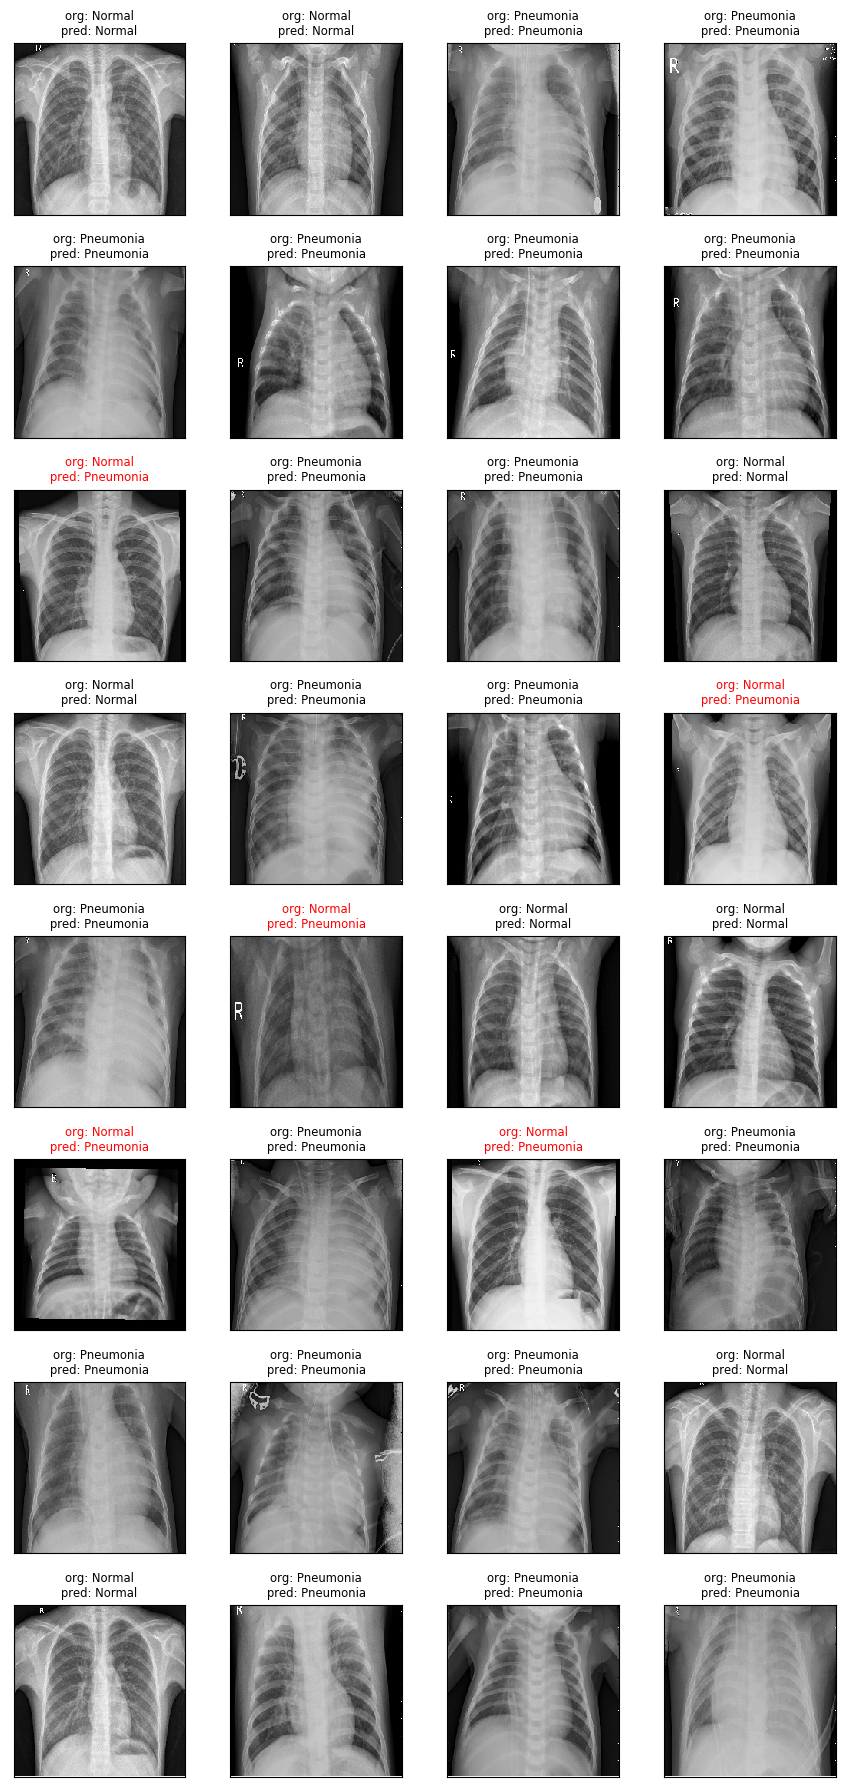

In [115]:
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

# figure(num=None, figsize=(8, 6), dpi=100, facecolor='w', edgecolor='k')

fig, axs = plt.subplots(nrows=8, ncols=4, figsize=(9, 18),
                        dpi=100, facecolor='w', edgecolor='k',
                        subplot_kw={'xticks': [], 'yticks': []})

plt.rcParams.update({'axes.titlesize': 'small'})
plt.subplots_adjust(hspace=0.5, wspace=0.3)


for i in range(0, batch_size_t): # how many imgs will show from the 3x3 grid
    plt.subplot(8, 4, i+1)
    plt.imshow(y_img_batch[i])
    plt.xticks([])
    plt.yticks([])
    if y_true_labels[i]==y_pred_labels[i]:
        plt.title("org: " + y_true_labels[i] + "\npred: " + y_pred_labels[i])
    else:
        plt.title("org: " + y_true_labels[i] + "\npred: " + y_pred_labels[i], color='red')
        
    fig.savefig("result", dpi=100)
plt.tight_layout()
plt.show()


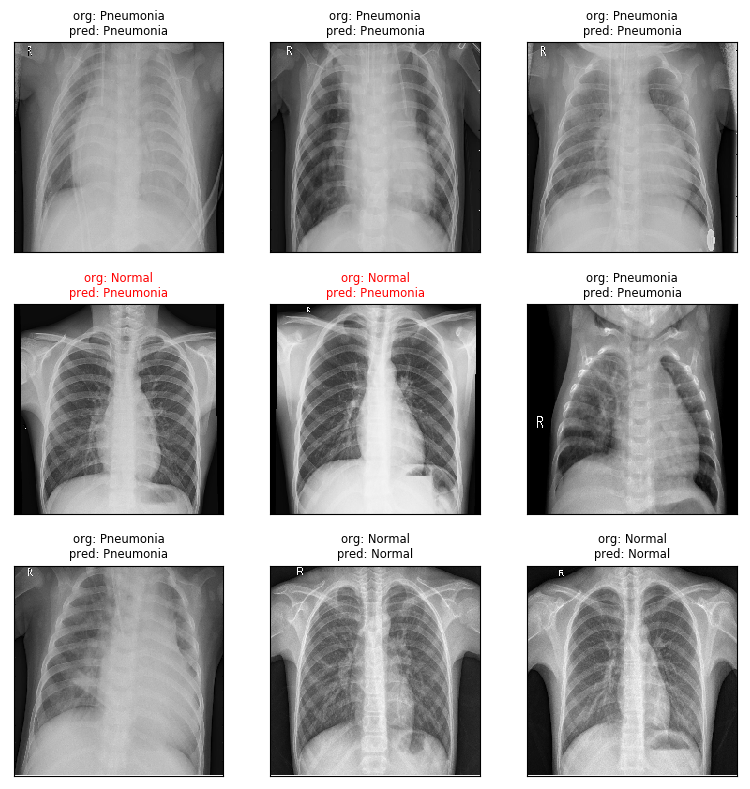

In [116]:
# ranfdomly selected image prediction visualization
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

# figure(num=None, figsize=(8, 6), dpi=100, facecolor='w', edgecolor='k')

fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(8, 8),
                        dpi=100, facecolor='w', edgecolor='k',
                        subplot_kw={'xticks': [], 'yticks': []})

plt.rcParams.update({'axes.titlesize': 'small'})
plt.subplots_adjust(hspace=0.5, wspace=0.3)


m = {}

for i in range(0,9): # how many imgs will show from the 3x3 grid
    num=-1
    while num in m:
        num = random.randint(0, 31)
    m[num]=1
    plt.subplot(3, 3, i+1)
    plt.imshow(y_img_batch[num])
    plt.xticks([])
    plt.yticks([])
    if y_true_labels[num]==y_pred_labels[num]:
        plt.title("org: " + y_true_labels[num] + "\npred: " + y_pred_labels[num])
    else:
        plt.title("org: " + y_true_labels[num] + "\npred: " + y_pred_labels[num], color='red')
        
    fig.savefig("sample", dpi=100)
plt.tight_layout()
plt.show()


In [ ]:
from IPython.display import display
from PIL import Image
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

CM = confusion_matrix(test_generator.classes, y_classes)
fig, ax = plot_confusion_matrix(conf_mat=CM ,  figsize=(12,8), hide_ticks=True,cmap=plt.cm.Blues)
plt.xticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
plt.yticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
plt.show()

In [37]:
target_names = ['Normal', 'Pneumonia']
print(classification_report(test_generator.classes, y_classes, target_names=target_names))

NameError: name 'classification_report' is not defined